In [3]:
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np

In [19]:
N_SAMPLES  = 5000
N_TESTS = 1000
(train_X, train_Y), (test_X, test_Y) = mnist.load_data()
train_X, train_Y = train_X[:N_SAMPLES], train_Y[:N_SAMPLES]
test_X, test_Y = test_X[:N_TESTS], test_Y[:N_TESTS]
train_X = train_X.reshape(train_X.shape[0], 28**2) / 255.0
test_X = test_X.reshape(test_X.shape[0], 28**2) / 255.0
train_X.shape, train_Y.shape, test_X.shape, test_Y.shape

((5000, 784), (5000,), (1000, 784), (1000,))

In [6]:
k = 1
ReLU = lambda x: np.maximum(0, k*x)
dReLU = lambda x: np.where(x > 0, k, 0)

def softmax(x):
    shiftx = x - np.max(x)
    exps = np.exp(shiftx)
    return exps / np.sum(exps)

def dsoftmax(x):
    s = softmax(x)
    return np.diagflat(s) - np.outer(s, s)

def MSE(y, y_ref):
    return 0.5 * np.mean((y - y_ref)**2)

def dMSE(y, y_ref):
    delta = y - y_ref
    return delta / delta.size

def KL_divergence(y, y_ref):
    return np.mean(y_ref * np.log((y_ref + 1e-9) / (y + 1e-9)))

def KL_divergence_derivative(y, y_ref):
    return -y_ref / (y + 1e-9)

def categorical_cross_entropy(y, y_ref):
    return -np.mean(y_ref * np.log(y + 1e-9))

def categorical_cross_entropy_derivative(y, y_ref):
   return y - y_ref


In [22]:
class Perceptron:
    def __init__(self, input_neurons, hidden_neurons, output_neurons,  hidden_layers_count, epochs=100, learning_rate=1e-3):
        self.initial_weights = []
        self.initial_biases = []
        self.activation_functions = []
        self.activation_derivatives = []
        self.epochs = epochs
        self.learning_rate = learning_rate
        layers = [input_neurons] + [hidden_neurons] * hidden_layers_count + [output_neurons]
        for i in range(1, len(layers)):
            W = np.random.randn(layers[i - 1], layers[i]) * 0.01
            b = np.zeros(layers[i])
            self.initial_weights.append(W)
            self.initial_biases.append(b)
            self.activation_functions.append(ReLU)
            self.activation_derivatives.append(dReLU)
        self.activation_functions[-1] = softmax
        self.activation_derivatives[-1] = dsoftmax

    def set_learning_rate(self, learning_rate):
        self.learning_rate = learning_rate

    def set_epochs(self, epochs):
        self.epochs = epochs

    def predict(self, x):
        activation = x
        for W, b, f in zip(self.weights, self.biases, self.activation_functions):
            activation = f(np.dot(activation, W) + b)

        return int(np.argmax(activation))
    
    def forward_and_backward(self, x, y_ref, loss_func, dloss_func):
        grads_w = [None] * len(self.weights)
        grads_b = [None] * len(self.biases)
        activations = [x]
        inputs = []
        for (W, b, f) in zip(self.weights, self.biases, self.activation_functions):
            weighted_sum = np.dot(activations[-1], W) + b
            inputs.append(weighted_sum)
            activations.append(f(weighted_sum))

        y = activations[-1]
        loss = loss_func(y, y_ref)
        delta_loss = dloss_func(y, y_ref)
        dZ = np.dot(delta_loss, dsoftmax(inputs[-1]))
        grads_w[-1] = np.outer(activations[-2], dZ)
        grads_b[-1] = dZ

        for i in range(len(self.weights) - 2, -1, -1):
            dA = np.dot(dZ, self.weights[i + 1].T)
            dZ = dA * self.activation_derivatives[i](inputs[i])
            grads_w[i] = np.outer(activations[i], dZ)
            grads_b[i] = dZ

        return grads_w, grads_b, loss
    
    def validate(self, X, Y, loss_func):
        correct_predictions = 0
        total_loss = 0.0
        for (x, y_ref) in zip(X, Y):
            activation = x
            for W, b, f in zip(self.weights, self.biases, self.activation_functions):
                activation = f(np.dot(activation, W) + b)
            total_loss +=  loss_func(activation, y_ref)

            if int(np.argmax(activation)) == np.argmax(y_ref):
                correct_predictions += 1
        return total_loss / len(X), correct_predictions / len(X)

    def train(self, train_X, train_Y, validate_X, validate_Y, loss_func, dloss_func):
        train_one_hot = np.array([np.array([int(i == y) for i in range(10)]) for y in train_Y])
        validate_one_hot = np.array([np.array([int(i == y) for i in range(10)]) for y in validate_Y])
        self.weights = [np.copy(w) for w in self.initial_weights]
        self.biases = [np.copy(b) for b in self.initial_biases]
        loss, accuracy = self.validate(validate_X, validate_one_hot, loss_func)
        losses = [loss]
        accuracies = [accuracy]
        for epoch in range(self.epochs):
            for (x, y_ref) in zip(train_X, train_one_hot):
                weight_grads, bias_grads, loss = self.forward_and_backward(
                    x, 
                    y_ref,
                    loss_func, 
                    dloss_func
                )

                for i in range(len(self.weights)):
                    self.weights[i] -= weight_grads[i] * self.learning_rate
                    self.biases[i] -= bias_grads[i] * self.learning_rate
            loss, accuracy = self.validate(validate_X, validate_one_hot, loss_func)
            losses.append(loss)
            accuracies.append(accuracy)

        return losses, accuracies


In [39]:
INPUT_SIZE = 28**2
OUTPUT_NEURONS = 10

def experiment(num_neurons, num_layers, epochs, learging_rate):
    epochs_axis = np.arange(epochs + 1)

    perceptron = Perceptron(INPUT_SIZE, num_neurons, OUTPUT_NEURONS, num_layers, epochs, learging_rate)

    mse_loss, mse_accuracy = perceptron.train(train_X, train_Y, test_X, test_Y, MSE, dMSE)

    cross_entropy_loss, cross_entropy_accuracy = perceptron.train(train_X, train_Y, test_X, test_Y,categorical_cross_entropy, categorical_cross_entropy_derivative)

    KL_divergence_loss, KL_divergence_accuracy = perceptron.train(train_X, train_Y, test_X, test_Y, KL_divergence, KL_divergence_derivative)
    
    plt.figure()
    plt.title(f"Зависимость функции потерь от количества эпох, скрытых слоев: {num_layers}, нейронов: {num_neurons}")
    plt.xlabel("Количество эпох")
    plt.ylabel("Значение функции потерь")
    plt.plot(epochs_axis, mse_loss, label = "MSE")
    plt.plot(epochs_axis, cross_entropy_loss, label = "Categorical cross entropy")
    plt.plot(epochs_axis, KL_divergence_loss, label = "KL divergence")
    plt.legend()
    plt.show()

    plt.figure()
    plt.title(f"Зависимость точности от количества эпох, скрытых слоев: {num_layers}, нейронов: {num_neurons}")
    plt.xlabel("Количество эпох")
    plt.ylabel("Точность")
    plt.plot(epochs_axis, mse_accuracy, label = "MSE")
    plt.plot(epochs_axis, cross_entropy_accuracy, label = "Categorical cross entropy")
    plt.plot(epochs_axis, KL_divergence_accuracy, label = "KL divergence")
    plt.legend()
    plt.show()

    return

[array([[-0.00387935, -0.006184  , -0.00405394, ..., -0.01244773,
        -0.01037969,  0.00912335],
       [ 0.00925004,  0.00027436,  0.01034018, ..., -0.00278558,
         0.01090368, -0.01928093],
       [-0.00476456, -0.01828567,  0.00798123, ..., -0.01572595,
        -0.00553685,  0.00569364],
       ...,
       [ 0.01146007, -0.00600142, -0.00059436, ...,  0.00241992,
         0.0044052 ,  0.00854931],
       [ 0.00112265,  0.00490517, -0.00731969, ...,  0.00726571,
        -0.03069309, -0.0008263 ],
       [ 0.00555144, -0.00204444, -0.0030693 , ..., -0.00530907,
        -0.01737526, -0.00940986]]), array([[-2.16679728e-01,  3.47910608e-01,  3.71270306e-01,
         1.18360081e-01, -3.15028671e-01,  4.64132167e-01,
        -1.83314244e-01,  5.90134162e-01, -4.08272426e-01,
        -7.75905288e-01],
       [-1.16729271e-02, -1.52507845e-01,  2.29861506e-01,
         5.11997889e-03, -2.00248751e-01,  3.15452663e-01,
        -3.27132639e-01, -4.23426451e-01,  5.71519291e-01,
     

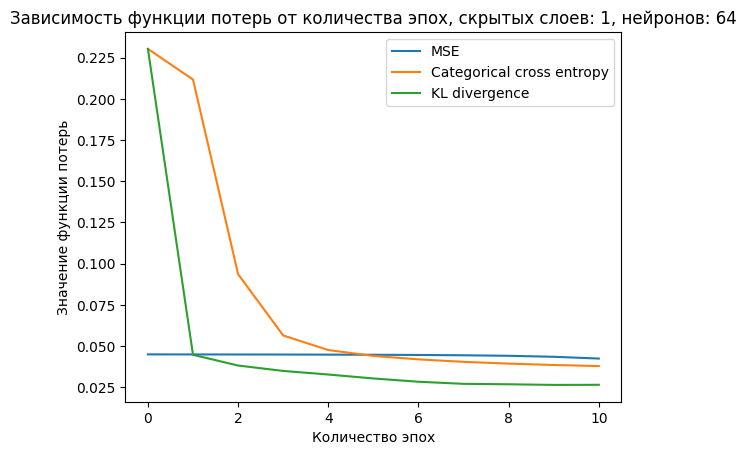

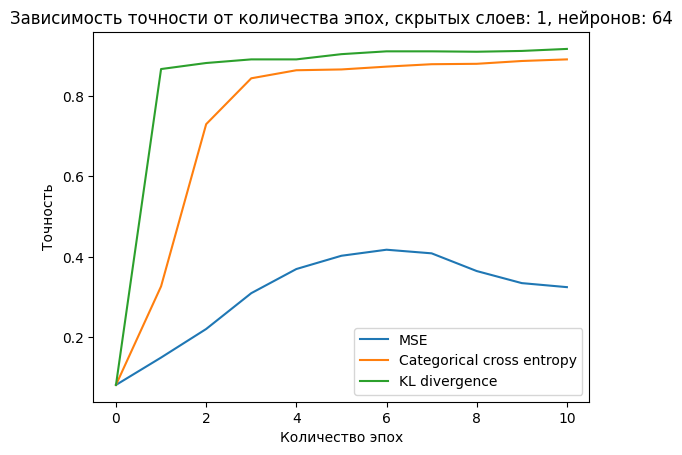

[array([[ 0.00913654,  0.0039872 ,  0.01577909, ...,  0.00612464,
        -0.00513968,  0.00275573],
       [-0.00753432, -0.0011041 , -0.00502112, ...,  0.00309712,
         0.01346189, -0.00012049],
       [-0.00596075,  0.02923768, -0.02232495, ...,  0.00155781,
         0.00427808, -0.01738138],
       ...,
       [-0.00820648, -0.01097598, -0.01042651, ..., -0.01048059,
        -0.00188203,  0.01811286],
       [ 0.01638577,  0.01008657,  0.00293513, ..., -0.0076928 ,
        -0.0009244 , -0.00933427],
       [ 0.00304915,  0.00954757,  0.00224139, ...,  0.01292712,
        -0.0099465 , -0.00151628]]), array([[ 1.65107304e-01, -6.18193088e-03, -2.82701601e-02, ...,
         5.99409226e-02,  1.05996103e-01, -5.83265595e-04],
       [ 1.18775027e-01, -1.00394029e-02,  4.43795567e-03, ...,
        -4.76820813e-02,  5.15201292e-02,  2.36189375e-03],
       [-1.67379057e-01,  3.26530222e-03,  2.91667313e-03, ...,
        -1.93226468e-01,  2.69946094e-02, -3.28997735e-04],
       ...,
 

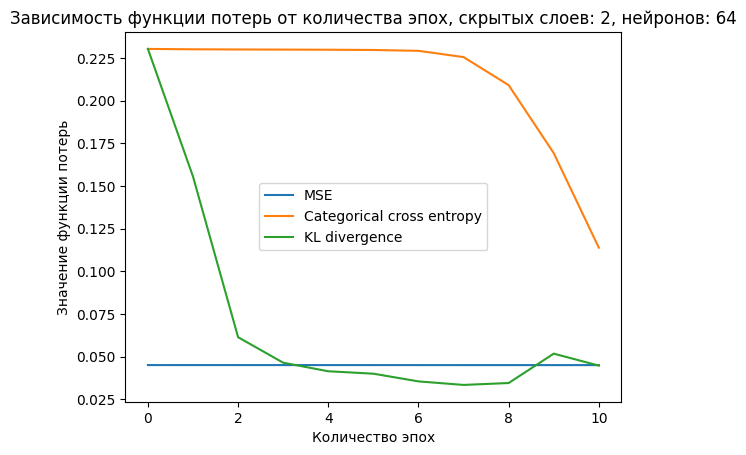

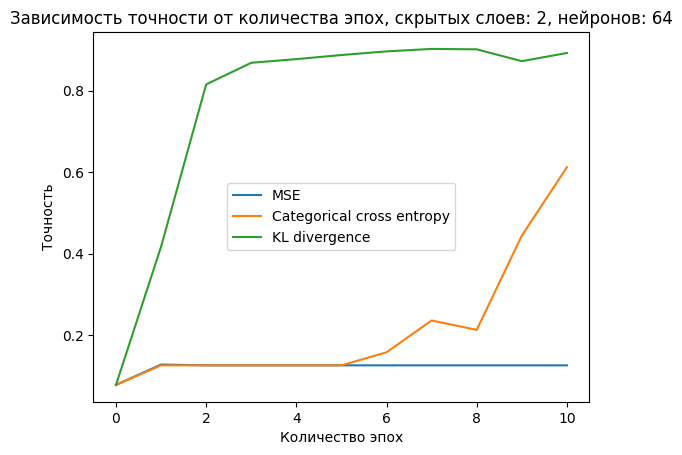

[array([[ 9.84141125e-03, -8.59769020e-03, -8.72425748e-03, ...,
         6.90395703e-03,  1.67326496e-02,  1.94507984e-03],
       [ 1.55830355e-02,  1.39252929e-02, -6.99633682e-03, ...,
        -5.10463697e-03,  3.01747854e-03,  5.67519496e-03],
       [ 5.28993281e-03, -9.22230910e-04, -2.02622316e-02, ...,
         5.62488237e-04, -8.90717273e-03, -9.13003224e-03],
       ...,
       [-1.90458116e-02,  9.57897348e-04, -1.95905984e-02, ...,
         1.65222970e-02, -4.78533493e-04, -8.81804627e-03],
       [-8.13017036e-03, -4.55766997e-03, -8.22062001e-04, ...,
        -1.42262098e-02, -1.21249895e-02,  1.18447817e-02],
       [-1.64292748e-02,  6.22409597e-03, -5.91751612e-03, ...,
        -8.34873186e-05,  4.30883283e-03,  6.33548128e-03]]), array([[ 7.18225963e-05,  4.75716553e-03, -1.18576813e-02, ...,
        -8.37600665e-03,  2.64687016e-02, -2.45045296e-03],
       [ 2.48514284e-03,  1.53189623e-02,  4.89384839e-02, ...,
         6.90386895e-02,  1.86833609e-03,  9.55586193

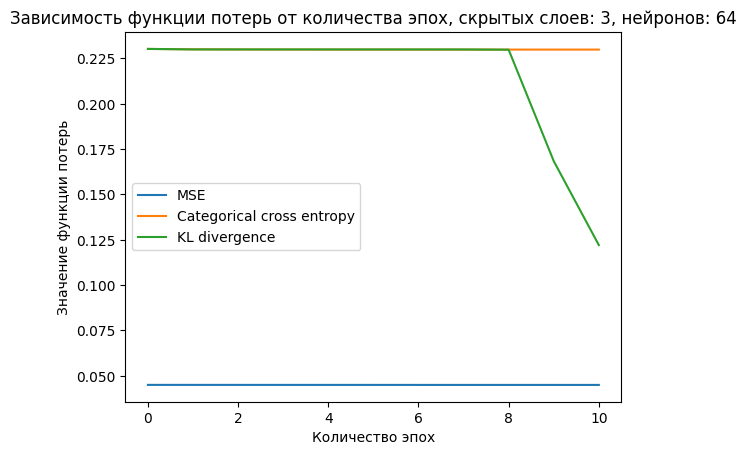

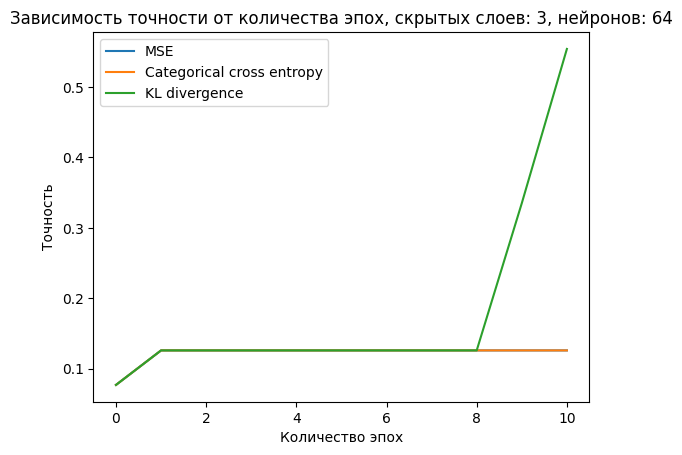

[array([[-0.00438654, -0.00327342,  0.01091634, ...,  0.00206815,
         0.00041654,  0.01416675],
       [ 0.00190465,  0.00118329,  0.0070364 , ...,  0.00643414,
         0.00703717, -0.01415306],
       [ 0.00374141, -0.00179413, -0.01177271, ..., -0.0034455 ,
        -0.00451841,  0.00932027],
       ...,
       [-0.00816753,  0.00320321, -0.00070856, ..., -0.0103638 ,
        -0.01800376,  0.00547646],
       [-0.02003942, -0.01824489, -0.0055817 , ..., -0.01112783,
         0.01030889, -0.00524162],
       [-0.00816607, -0.00585782,  0.00012571, ..., -0.01053664,
        -0.00583936, -0.01039922]]), array([[ 2.88462163e-03, -4.55949873e-03,  1.18626692e-02, ...,
         1.41421751e-02, -1.24781466e-02, -8.50012075e-03],
       [-8.86875877e-03, -4.21208793e-03,  6.06259441e-03, ...,
        -1.16837541e-02,  7.79292502e-06,  2.56484956e-03],
       [ 9.94245852e-03,  1.92374091e-03,  9.41351269e-03, ...,
         9.28835593e-03,  5.46900948e-03,  6.41793859e-04],
       ...,
 

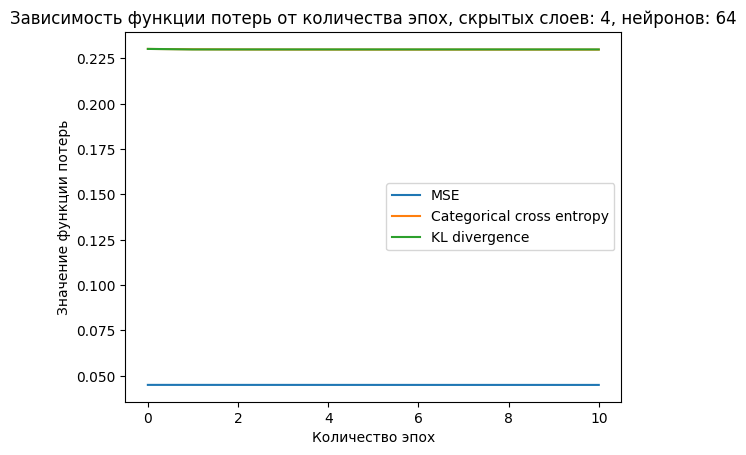

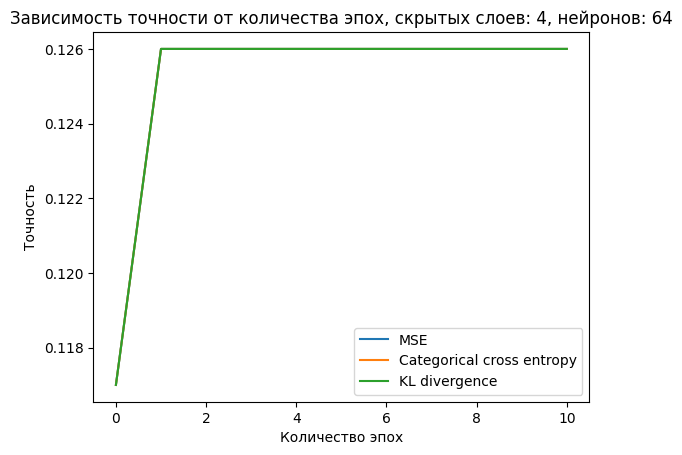

In [40]:
N_EPOCHS = 10
LEARNING_RATE = 0.009
num_layers_range = [1, 2, 3, 4]
for num_layers in num_layers_range:
    experiment(64, num_layers, N_EPOCHS, LEARNING_RATE)    
 

# num_neurons_range = [32, 64, 128]
# for neurons_num in num_layers_range:
#     experiment(neurons_num, 2, N_EPOCHS, LEARNING_RATE)     
  